#### Prerequisites

- Basic familiarity with [Numpy](https://numpy.org/doc/stable/user/quickstart.html)
- Basic familiarity with [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)
- Basic familiarity with [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)


## Outline

- [Section 1](#section-1): Dataset Preparation
- [Section 2](#section-2): Linear SVM Formulation
- [Section 3](#section-3): SVM Optimization using SGD
- [Section 4](#section-4): Model Evaluation via *T*-fold Cross Validation


# Support Vector Machines (SVMs)
In this notebook, we will learn a linear and kernalised method of SVMs, which can be used for both regression and classification. To start with, we will focus on binary classification. We will use stochastic gradient descent (SGD) for the optimisation of the hinge loss.

We will work with the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data), which you first need to download and then load in this notebook. If you faced difficulties downloading this data set from Kaggle, you should download the file directly from Blackboard. The data set contains various aspects of cell nuclei of breast screening images of patients with _(malignant)_ and without _(benign)_ breast cancer. Our goal is to build a classification model that can take these aspects of an unseen breast screening image, and classify it as either malignant or benign.

<a name="section-1"></a>

## Section 1: Data Preparation

If you run this notebook locally on your machine, you will simply need to place the `csv` file in the same directory as this notebook.
If you run this notebook on Google Colab, you will need to use

  `from google.colab import files`

  `upload = files.upload()`

and then upload it from your local downloads directory.

In [ ]:
# necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#from google.colab import files
#upload = files.upload()
data = pd.read_csv('./data.csv')

# print shape and last 10 rows
print(data.shape)
data.tail(10)

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
559,925291,B,11.51,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.04105,...,37.16,82.28,474.2,0.12980,0.25170,0.3630,0.09653,0.2112,0.08732,NaN
560,925292,B,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,...,33.17,100.20,706.7,0.12410,0.22640,0.1326,0.10480,0.2250,0.08321,NaN
561,925311,B,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.00000,...,38.30,75.19,439.6,0.09267,0.05494,0.0000,0.00000,0.1566,0.05905,NaN
562,925622,M,15.22,30.62,103.40,716.9,0.10480,0.20870,0.25500,0.09429,...,42.79,128.70,915.0,0.14170,0.79170,1.1700,0.23560,0.4089,0.14090,NaN
563,926125,M,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,...,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.25420,0.2929,0.09873,NaN
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.22160,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.16280,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.14180,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.26500,0.4087,0.12400,NaN
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.00000,0.2871,0.07039,NaN


We can see that our data set has 569 samples and 33 columns. The column `id` can be taken as an index for our pandas dataframe and `diagnosis` is the label (either **M: malignant** or **B: benign**).

Let's prepare the data set first of all by (i) cleaning it, (ii) separating label from features, and (iii) splitting it into train and test sets.

In [ ]:
# drop last column (extra column added by pd)
data_1 = data.drop(data.columns[-1], axis=1)

# set column id as dataframe index
data_2 = data_1.set_index(data['id']).drop(data_1.columns[0], axis=1)

# check
data_2.tail()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


We do a bit more preparation by converting the categorical labels into 1 for **M** and -1 for **B**.

In [ ]:
# convert categorical labels to numbers
diag_map = {'M': 1.0, 'B': -1.0}
data_2['diagnosis'] = data_2['diagnosis'].map(diag_map)

# put labels and features in different dataframes
y = data_2.loc[:, 'diagnosis']
X = data_2.iloc[:, 1:]

# check
print(y.tail())
X.tail()

id
926424    1.0
926682    1.0
926954    1.0
927241    1.0
92751    -1.0
Name: diagnosis, dtype: float64


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
926424,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
926682,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
926954,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
927241,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
92751,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


As with any data set that has features over different ranges, it's required to standardise the data before.

In [ ]:
## EDIT THIS FUNCTION
def standardise(X):
  mu = np.mean(X, 0)
  sigma = np.std(X, 0)
  X_std = ... ## <-- EDIT THIS LINE
  return X_std

In [ ]:
X_std = standardise(X)

# check
X_std.tail()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
926424,2.110995,0.721473,2.060786,2.343856,1.041842,0.219060,1.947285,2.320965,-0.312589,-0.931027,...,1.901185,0.117700,1.752563,2.015301,0.378365,-0.273318,0.664512,1.629151,-1.360158,-0.709091
926682,1.704854,2.085134,1.615931,1.723842,0.102458,-0.017833,0.693043,1.263669,-0.217664,-1.058611,...,1.536720,2.047399,1.421940,1.494959,-0.691230,-0.394820,0.236573,0.733827,-0.531855,-0.973978
926954,0.702284,2.045574,0.672676,0.577953,-0.840484,-0.038680,0.046588,0.105777,-0.809117,-0.895587,...,0.561361,1.374854,0.579001,0.427906,-0.809587,0.350735,0.326767,0.414069,-1.104549,-0.318409
927241,1.838341,2.336457,1.982524,1.735218,1.525767,3.272144,3.296944,2.658866,2.137194,1.043695,...,1.961239,2.237926,2.303601,1.653171,1.430427,3.904848,3.197605,2.289985,1.919083,2.219635
92751,-1.808401,1.221792,-1.814389,-1.347789,-3.112085,-1.150752,-1.114873,-1.261820,-0.820070,-0.561032,...,-1.410893,0.764190,-1.432735,-1.075813,-1.859019,-1.207552,-1.305831,-1.745063,-0.048138,-0.751207


In [ ]:
# split into train and test set
# stacking data X and labels y into one matrix
data_split = np.hstack((X_std, y[:, np.newaxis]))
# There can be a bug caused by Python versions, try also data_split = np.hstack((X_std, np.array(y)[:, np.newaxis]))

# shuffling the rows
np.random.shuffle(data_split)

# we split train to test as 70:30
split_rate = 0.7
train, test = np.split(data_split, [int(split_rate*(data_split.shape[0]))])

X_train = train[:,:-1]
y_train = train[:, -1]

X_test = test[:,:-1]
y_test = test[:, -1]

y_train = y_train.astype(float)
y_test = y_test.astype(float)

# insert 1 in every row for intercept b
X_train_intercept = np.hstack((X_train, np.ones((len(X_train),1)) ))
X_test_intercept = np.hstack((X_test, np.ones((len(X_test),1)) ))

/home/andreas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<a name="section-2"></a>

## Section 2: Linear SVM Formulation

We start with defining the hinge loss as
$$
\mathcal L (\boldsymbol w) = \frac{1}{2} \| \boldsymbol w \|^2 + \lambda \sum_{i=1}^n \max \bigg( 0, 1-y_i (x^{(i)} \cdot \boldsymbol w  + b) \bigg) \, .
$$
where $\boldsymbol w$ is the vector of weights, $\lambda$ the regularisation parameter, and $b$ the intercept which is included in our `X` as an additional column of $1$'s.

In [ ]:
# EDIT THIS FUNCTION
def compute_cost(w, X, y, regul_strength=1e5):
  n = X.shape[0]
  distances = 1 - ...  ## <-- EDIT THIS LINE
  distances[distances < 0] = 0  # equivalent to max(0, distance)
  hinge = regul_strength * ...  ## <-- EDIT THIS LINE

  # calculate cost
  return 0.5 * np.dot(w, w) + hinge - 0.5 * w[-1] ** 2
  # here, the w actually has the last term b, so we take it out of the regularisation

<a name="section-3"></a>

## Section 3: SVM Optimization using SGD

One way to optimize the cost is by using stochastic gradient descent (SGD) algorithm. In order to use SGD, we need to implement a function for the cost gradients with respect to $\boldsymbol w$.

In [ ]:
# calculate gradient of cost
def calculate_cost_gradient(w, X_batch, y_batch, regul_strength=1e6):
  # if only one example is passed
  if type(y_batch) == np.float64:
      y_batch = np.asarray([y_batch])
      X_batch = np.asarray([X_batch])  # gives multidimensional array

  distance = 1 - (y_batch * (X_batch @ w))
  dw = np.zeros(len(w))

  for ind, d in enumerate(distance):
      if ... : ## <-- EDIT THIS LINE
          di = ...  ## <-- EDIT THIS LINE
      else:
          di = ...  ## <-- EDIT THIS LINE
      dw += di

  return dw/len(y_batch)  # average

Both of the two previous functions are then used in SGD to update the weights iteratively with a given learning rate $\alpha$. We also implement a stop criterion that ends the learning as soon as the cost function has not changed more than a manually determined percentage.

We know that the learning happens through updating the weights according to
$$
\boldsymbol w = \boldsymbol w - \alpha \frac{\partial \mathcal L}{\partial \boldsymbol w}
$$

where $\frac{\partial \mathcal L}{\partial \boldsymbol w}$ is the gradient of the hinge loss we have computed in the previous cell.

In [ ]:
# EDIT THIS FUNCTION
def sgd(X, y, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e6, print_outcome=False):

  # initialise zero weights
  weights = np.zeros(X.shape[1])
  nth = 0
  # initialise starting cost as infinity
  prev_cost = np.inf
  # record costs
  cost_list = []
  iteration_list = []

  # stochastic gradient descent
  indices = np.arange(len(y))

  for iteration in range(max_iterations):
    # shuffle to prevent repeating update cycles
    np.random.shuffle(indices)
    X, y = X[indices], y[indices]

    for xi, yi in zip(X, y):
      descent = ... ## <-- EDIT THIS LINE
      weights = ... ## <-- EDIT THIS LINE

    # convergence check on 2^n'th iteration
    if iteration==2**nth or iteration==max_iterations-1:
      # compute cost
      cost = ... ## <-- EDIT THIS LINE
      if print_outcome:
        print("Iteration is: {}, Cost is: {}".format(iteration, cost))
      # stop criterion
      if ... < stop_criterion * prev_cost: ## <-- EDIT THIS LINE
        return weights, cost_list, iteration_list

      prev_cost = cost
      iteration_list.append(iteration)
      cost_list.append(cost)
      nth += 1

  return weights, cost_list, iteration_list

Now, we can take these functions and train a linear SVM with our training data.

In [ ]:
# train the model
lam=10
w, costs, iterations = sgd(X_train_intercept, y_train, max_iterations=2000, stop_criterion=0.001, learning_rate=1e-5, regul_strength=lam, print_outcome=True)
print("Training finished.")

We can plot the cost against the iteractions to check nothing went wrong

In [ ]:
plt.plot(iterations, costs)
plt.title('Training costs')

plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

To evaluate the mean accuracy in both train and test set, we write a small function called `score`.

In [ ]:
## EDIT THIS FUNCTION
def score(w, X, y):
  y_preds = np.sign(X @ w)
  return 0.0 ## <-- EDIT THIS LINE

print("Accuracy on training set: {}".format(score(w, X_train_intercept, y_train)))
print("Accuracy on test set: {}".format(score(w, X_test_intercept, y_test)))

Accuracy on training set: 0.9849246231155779
Accuracy on test set: 0.9766081871345029


#### Questions:
1. What are other evaluation metrics besides the accuracy? Implement them and assess the performance of our classification algorithm with them.
2. What makes other evaluation metrics more appropriate given our unbalanced data set _(we have more benign than malignant examples)_?
3. Try different learning rates, regularisation strengths and number of iterations independently. What can you observe? Can you achieve higher accuracies?
4. What is your understanding why have we used the hinge loss with this data set of 31 features?

<a name="section-4"></a>

## Section 4: Model Evaluation via *T*-fold Cross Validation

Now we repeat the same procedure as above but do not only have one train-test split, but multiple in a *T*-fold cross validation method.

In [ ]:
def cross_val_split(N, num_folds):
  fold_size = N // num_folds
  index_perm = np.random.permutation(np.arange(N))
  folds = []
  for k in range(num_folds):
    folds.append(index_perm[k*fold_size:(k+1)*fold_size])
  return folds

In [ ]:
# evaluate
folds = cross_val_split(train.shape[0], 5)
folds

[array([109, 222,  23, 202, 188,  34, 234, 191, 219, 104, 329, 360, 385,
         60,  10, 213,   9, 345, 387, 173, 151, 223, 119, 233, 300,  74,
        392, 100,  68, 296, 357,  45, 171, 184, 179, 322, 156, 172, 256,
        364, 349, 325, 280, 106, 384, 246,  26, 272,  82,  56, 249, 331,
        260, 374,  63, 323, 332,  21,  75,  97,  13,  38, 338, 189, 185,
        196,  66, 178, 348, 201, 180, 274, 393, 132, 397, 115,  49, 124,
        366]),
 array([142, 334, 313, 394, 242, 367, 261,  85,  17,  50, 107, 324, 240,
        375,  40, 163, 258,   2, 301, 243,  12, 218, 307,  57,  39,  88,
        304,   3, 231, 162, 391, 137,  70,  99, 226,  48, 145, 235, 193,
        209, 170, 379,  67, 161, 181, 157, 111, 254,  55, 336,   8, 303,
        207, 183, 244, 312, 187, 228, 110, 268, 257, 372, 286, 103, 250,
         27, 344, 112, 200, 356, 237, 125, 146,  51,  80,  72, 373, 216,
        164]),
 array([347,  96, 326, 263,  33, 205, 276,  46, 168, 380,  83,  14, 314,
        197, 160,  30

In [ ]:
## EDIT THIS FUNCTION
def cross_val_evaluate(data, num_folds):
  folds = cross_val_split(data.shape[0], num_folds)

  train_scores = []
  val_scores = []

  for i in range(len(folds)):
    print('Fold', i+1)

    val_indices = folds[i]
    # define the training set
    train_indices = list(set(range(data.shape[0])) - set(val_indices))

    X_train = data[:,  1]  ## <-- EDIT THIS LINE
    y_train = data[train_indices, -1]

    # define the validation set
    X_val = data[:,  1]  ## <-- EDIT THIS LINE
    y_val = data[:, -1]  ## <-- EDIT THIS LINE

    # insert 1 in every row for intercept b
    X_train = np.hstack((X_train, np.ones((len(X_train),1)) ))
    X_val = np.hstack((X_val, np.ones((len(X_val),1)) ))

    # train the model
    w,_,_ = sgd(X_train, y_train, max_iterations=1025, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e3)
    print("Training finished.")

    # evaluate
    train_score = score(w, X_train, y_train)
    val_score = score(w, X_val, y_val)
    print("Accuracy on training set #{}: {}".format(i+1, train_score))
    print("Accuracy on validation set #{}: {}".format(i+1, val_score))

    train_scores.append(train_score)
    val_scores.append(val_score)

  return train_scores, val_scores

In [ ]:
train_scores, val_scores = cross_val_evaluate(train, 5)

Fold 1
Training finished.
Accuracy on training set #1: 0.9905956112852664
Accuracy on validation set #1: 0.9873417721518988
Fold 2
Training finished.
Accuracy on training set #2: 0.9905956112852664
Accuracy on validation set #2: 0.9746835443037974
Fold 3
Training finished.
Accuracy on training set #3: 0.9905956112852664
Accuracy on validation set #3: 0.9746835443037974
Fold 4
Training finished.
Accuracy on training set #4: 0.9905956112852664
Accuracy on validation set #4: 0.9746835443037974
Fold 5
Training finished.
Accuracy on training set #5: 0.9937304075235109
Accuracy on validation set #5: 0.9367088607594937


Finally, let's compute the mean accuracy.

In [ ]:
print(np.mean(train_scores), np.mean(val_scores))

0.9912225705329153 0.969620253164557


### Subsection 4.1: Kernelised SVM

In the follwing, we implement a soft-margin kernelised SVM classifier with a non-linear kernel. Here, we use a Gaussian kernel:
$$k(x,y|\sigma) = e^{-\frac{||x-y||^2}{\sigma}}$$

In [ ]:
# First we need a function to calculate the kernel given the data #
def kernel_matrix(X1,X2,sigma):

    n1,m1 = X1.shape
    n2,m2 = X2.shape
    kernel = np.zeros((n1,n2))

    # Here we define a Gaussian Radial Basis Function Kernel #
    for i in range(n1):
        exponent = ... ## <-- EDIT THIS LINE
        kernel[i,:] = np.exp(-exponent/sigma)

    return kernel

Having defined the kernel, we use this to compute the cost below.

In [ ]:
## EDIT THIS FUNCTION
def compute_cost_kernel(u, K, y, regul_strength=1e3,intercept=0):

    # Here I define the hinge cost with the kernel trick. NB: the intercept should be kept separate #

    distances = 1 - ... ## <-- EDIT THIS LINE
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * distances.mean()

    # calculate cost
    return 0.5 * np.dot(u,K@u) + hinge

As we have seen in the lecture notes, the kernel trick can be implemented in the primal-form problem by defining a new loss function:

$$L(\mathbf{u},b) = \frac{1}{2}\mathbf{u}^{\rm{T}}\mathbf{K} \mathbf{u} + \lambda \sum_{i=1}^N  \max \Big\{0, 1-y^{(i)}(\mathbf{K}^{(i)}\mathbf{u} + b)\Big\}$$,

where $\mathbf{K}$ is the matrix containing the kernel functions, i.e.
 $\mathbf{K}_{ij} = k(\mathbf{x}^{(i)},\mathbf{x}^{(i)})$. To perform the optimisation, we simply modify the functions introduced above. Note that we will use $X_{\mathrm{train}}$ and $X_{\mathrm{test}}$ without the additional vector of ones. We had previously included this vector of ones to learn the intercept term $b$, but within the new formulation, one cannot readily employ this trick. For simplicity, we will drop the intercept by setting $b=0$ here. We are hinting at how you could implement the intercept, but we have deliberately left out a few lines of code for you to work on in the course work (2023).

Following the steps above, we want to optimize the cost is by using SGD. First, we thus create a function that computes the gradients.

In [ ]:
## EDIT THIS FUNCTION
def calculate_cost_gradient_kernel(u, K_batch, y_batch, regul_strength=1e3,intercept=0):

    # if only one example is passed
    if type(y_batch) == np.float64 or type(y_batch) == np.int32:
        y_batch = np.asarray([y_batch])
        K_batch = np.asarray([K_batch])  # gives multidimensional array

    distance = 1 - ... ## <-- EDIT THIS LINE
    dw = np.zeros(len(u))
    di_intercept = 0

    # define the gradient with the hinge loss #
    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = ... ## <-- EDIT THIS LINE
        else:
            di = K_batch@u - ... ## <-- EDIT THIS LINE
            di_intercept += ... ## <-- EDIT THIS LINE
        dw += di

    return dw/len(y_batch), di_intercept/len(y_batch)

We can now use the functions above in SGD.

In [ ]:
## EDIT THIS FUNCTION
def sgd_kernel(K, y, batch_size=32, max_iterations=4000, stop_criterion=0.001, learning_rate=1e-4, regul_strength=1e3, print_outcome=False):

    # initialise zero u and intercept
    u = np.zeros(K.shape[1])
    intercept=0

    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf

    # stochastic gradient descent
    indices = np.arange(len(y))
    for iteration in range(max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        K_b, y_b = K[batch_idx], y[batch_idx]
        for ki, yi in zip(K_b, y_b):
            ascent, ascent_intercept = ... ## <-- EDIT THIS LINE
            u = u - (learning_rate * ascent)
            intercept = ... ## <-- EDIT THIS LINE

        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = ... ## <-- EDIT THIS LINE
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if ... < stop_criterion * prev_cost: ## <-- EDIT THIS LINE
                return u, intercept

            prev_cost = cost
            nth += 1

    return u, intercept

Finally, let's compare some differnet values of *σ*.

In [ ]:
## EDIT THIS FUNCTION

for sigma in [1,2,5,10]:

    print('For sigma = ' + str(sigma))
    K_train = kernel_matrix(X_train,X_train, sigma) # note X_train doesn't have 1's attached

    u,b = sgd_kernel(K_train, y_train, batch_size=128, max_iterations=2000, stop_criterion=0.001, learning_rate=1e-5, regul_strength=1e3, print_outcome=False)

    def score(u, X, y, sigma, intercept):
        ## now I define the kernel containing test and train data ##
        K_test = kernel_matrix(X,X_train, sigma)

        ## The
        y_preds = ... ## <-- EDIT THIS LINE

        return np.mean(y_preds == y)

    print("Accuracy on training set: {}".format(score(u, X_train, y_train, sigma, b)))
    print("Accuracy on test set: {}".format(score(u, X_test, y_test, sigma, b)))

#### Questions:
1. What do you observe varying sigma?
2. How does the Gaussian Kernel SVM compare to the linear SVM?

## Section 5: How to make a nice plot ...

In your coursework, we ask you to produce some plots. Here, we outline how a "good" plot looks. For this purpose, let's consider a specific example based on the data in this notebook. Thus, let's plot the diagnosis (malignant or benign) in a scatter plot as a function of, say, the two first features (radius_mean and texture_mean). If we just plot the data using the standard settings, we don't end up with a very good plot.

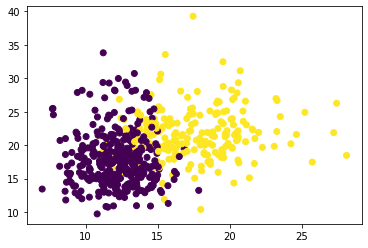

In [ ]:
plt.scatter(data_2.iloc[:, 1],data_2.iloc[:, 2],c=y);

The problem is the following: As a rule of thumb, **a plot should always be able to stand alone**. In other words, it should be possible to understand the plot without reading the surrounding code or text and even (if possible) without reading the figure caption. The plot above can clearly not stand on its own. For starters, it doesn't have any legend, nor does it have labels on the axes. Likewise, we should add a title. Other types of plots might have other options to add information. For instance, if we were dealing with a contour plot, we might want to include a colour bar or add labels to the contour lines.

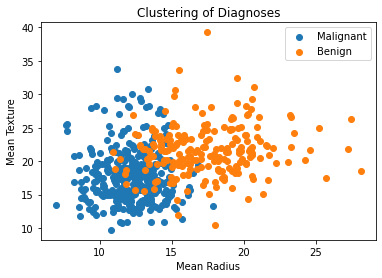

In [ ]:
labels = ["Malignant", "Benign"]
for i, c in enumerate(np.unique(y)):
    plt.scatter(data_2.iloc[:, 1][y==c],data_2.iloc[:, 2][y==c],label=labels[i]);
plt.xlabel("Mean Radius");
plt.ylabel("Mean Texture");
plt.title("Clustering of Diagnoses");
plt.legend();

These small additions have improved the plot significantly. But it's still not optimal. First of all, it's rather small. To make it more readable, we should increase the figure size and change the font size of the different labels, titles, and ticks. Now, what is a suitable font size? As a rule of thumb, **a plot should be easy to read when you print it**. If you printed the notebook, the plot would be a bit on the small side since the text is smaller than the text in the cells; thus, if someone scrolls through your notebook, they would probably have to zoom in.

Secondly, we might want to reconsider the markers. Indeed, there is an addition to the rule stated above: A plot should be easy to read when you print it **in grayscale**. The idea is that you make the plot colourblind-friendly if you ensure that your plot is grayscale convertible. Thus, use [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) that have this property. The default colormap of plt.scatter is actually grayscale convertible, leading to the choice of yellow and purple markers in the first plot in this section. While the notebook changed colours when creating the second plot, it chose colours that were "luckily" likewise grayscale convertible. If in doubt, you can, of course, use your own colour scheme, as shown below. Another way to make the plot more readable when printed in grayscale (and hence more readable in general) is to use different markers in addition to colours that are easily distinguishable. We, therefore, also change the markers themselves below. You can use the same trick when you make other plots. If you were to make, say, a line plot, you could consider, e.g., using different line styles ("-",":","--").

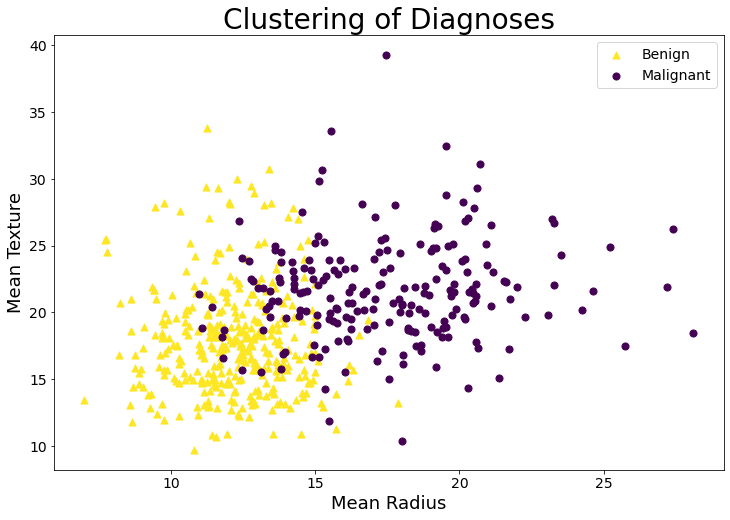

In [ ]:
fig, ax = plt.subplots(figsize=(12,8)) # We make plot larger

markers = ["^","o"] # We use distinct markers
labels = ["Benign", "Malignant"]
col = ['#fde724','#440154']; # We want to change back to the yellow and purple used above.
fsize = 14 # We set fontsize

for i, c in enumerate(np.unique(y)):
    ax.scatter(data_2.iloc[:, 1][y==c],data_2.iloc[:, 2][y==c],c=col[i],marker=markers[i],label=labels[i],s=50);

ax.legend(loc="best",fontsize=fsize);
plt.xlabel("Mean Radius",fontsize=fsize+4);
plt.ylabel("Mean Texture",fontsize=fsize+4);
plt.xticks(size=fsize); # We change the size of the ticks
plt.yticks(size=fsize); # We change the size of the ticks
plt.title("Clustering of Diagnoses",fontsize=2*fsize);

The plot above is what we would consider a "good" plot since it fulfils both the criteria sketched above: It can stand alone, and it's easy to read. But what if we had decided to plot something different, such as the regularisation for the kernelised SVM, i.e. sigma? In that case, LaTeX commands would be useful for writing $\sigma$ rather than "sigma". Indeed, we can readily do so in Python by passing a raw string (r"") with a LaTeX command. So, for the sake of the example, let's say that we have called the radius *R* and the texture $\tau$.

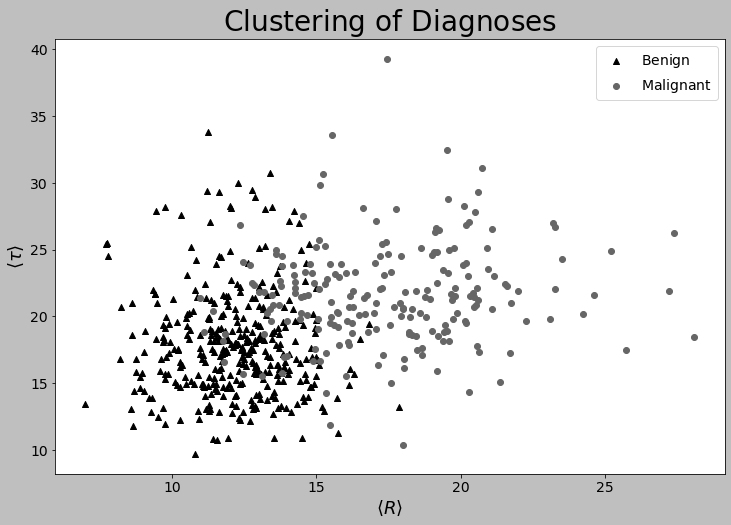

In [ ]:
# The plots in your report should be in colour. But just to show what we mean with grayscale convertable...
plt.style.use('grayscale')

fig, ax = plt.subplots(figsize=(12,8))
markers = ["^","o"]
labels = [r"$\mathrm{Benign}$", r"$\mathrm{Malignant}$"] # We now use LaTeX commands
fsize = 14 # Change fontsize
for i, c in enumerate(np.unique(y)):
    ax.scatter(data_2.iloc[:, 1][y==c],data_2.iloc[:, 2][y==c],marker=markers[i],label=labels[i]);

ax.legend(loc="best",fontsize=fsize);
plt.xlabel(r"$\langle R \rangle$",fontsize=fsize+4);
plt.ylabel(r"$\langle \tau \rangle$",fontsize=fsize+4);
plt.xticks(size=fsize);
plt.yticks(size=fsize);
plt.title(r"$\mathrm{Clustering \,\, of \,\, Diagnoses}$",fontsize=2*fsize);

#### Questions:
1. Go back to the notebooks from the previous weeks and improve the quality of the plots.